In [178]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from re import sub
from decimal import Decimal
from scipy import stats
import seaborn as sns
from textwrap import fill
from wordcloud import WordCloud
import folium as fl
from folium.plugins import HeatMap
from folium.plugins import PolyLineTextPath
from urllib.request import Request, urlopen


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [179]:
listings_file = 'data/listings 2.csv'

'''set variable for with type of room you are interested in:
    'Entire home/apt'
    'Private room'
    'Hotel room'
    'Shared room'
    To return all room types, set value to 'All'
'''
room_type = 'All'

In [180]:
listings_detailed_df=pd.read_csv('Data/listings 2.csv')

In [181]:
listings_detailed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2563 non-null   int64  
 1   listing_url                                   2563 non-null   object 
 2   scrape_id                                     2563 non-null   int64  
 3   last_scraped                                  2563 non-null   object 
 4   name                                          2563 non-null   object 
 5   description                                   2557 non-null   object 
 6   neighborhood_overview                         2001 non-null   object 
 7   picture_url                                   2563 non-null   object 
 8   host_id                                       2563 non-null   int64  
 9   host_url                                      2563 non-null   o

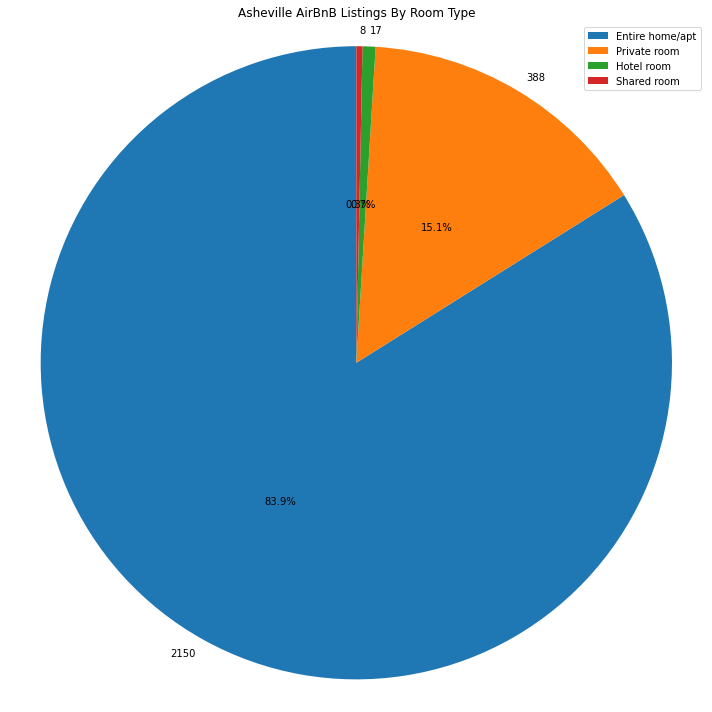

In [182]:
def pie_chart_for_column_value_by_percentage(df, column, title, imagename):
    labels = df[column].value_counts().index
    sizes = df[column].value_counts().values
    #explode = (0.1, 0, 0, 0)  
    fig1, ax1 = plt.subplots(figsize=(10,10))
    ax1.pie(sizes,  autopct='%1.1f%%',labels=sizes,
        shadow=False, startangle=90, pctdistance=.5, labeldistance=1.05)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.legend(bbox_to_anchor=(1.0, 1.0), labels=labels, loc='upper right')
    plt.title(title)
    plt.savefig('images/' + imagename + '.png')
    plt.tight_layout()
    plt.show()

pie_chart_for_column_value_by_percentage(listings_detailed_df,'room_type','Asheville AirBnB Listings By Room Type', 'All Room Type by Percentage')

In [225]:
keeper_columns = ['id',
                'name',
                'host_id',
                'host_name',
                'neighbourhood',
                'neighborhood_overview',
                'host_since',
                'host_location',
                'host_listings_count',
                'host_total_listings_count',
                'neighbourhood',
                'latitude',
                'longitude',
                'room_type',
                'price',
                'minimum_nights',
                'number_of_reviews',
                'last_review',
                'reviews_per_month',
                'calculated_host_listings_count',
                'availability_30',
                'availability_365',
                'number_of_reviews_ltm',
                 'number_of_reviews_l30d',
                 'first_review',
                 'last_review',
                 'review_scores_rating',
                 'review_scores_accuracy',
                 'review_scores_cleanliness',
                 'review_scores_location', 'review_scores_value',
                 'license',
                 'calculated_host_listings_count', 
                  'calculated_host_listings_count_entire_homes', 
                  'calculated_host_listings_count_private_rooms', 
                  'calculated_host_listings_count_shared_rooms',
                 'reviews_per_month',
                  'gross_income_30',
                  'airbnb_host_fee',
                  'airbnb_profit_30',
                  'bedrooms',
                  'bathrooms',
                  'bathrooms_text',
                  'cleaning_fee',
                  'percentage_occupied',
                  'net_income_30',
                  'cleaners_fee_30'
                 ]


In [226]:
listings_detailed_df.info(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2563 entries, 0 to 2562
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2563 non-null   int64  
 1   listing_url                                   2563 non-null   object 
 2   scrape_id                                     2563 non-null   int64  
 3   last_scraped                                  2563 non-null   object 
 4   name                                          2563 non-null   object 
 5   description                                   2557 non-null   object 
 6   neighborhood_overview                         2001 non-null   object 
 7   picture_url                                   2563 non-null   object 
 8   host_id                                       2563 non-null   int64  
 9   host_url                                      2563 non-null   o

In [10]:
#listings_detailed_df['price'].map(Decimal(sub(r'[^\d.]', '', listings_detailed_df['price'])))
#listings_detailed_df['price'] = pd.to_numeric(listings_detailed_df['price'].str.replace("$","").str.replace(",",""), downcast="float")

In [232]:
def determine_avg_cleaning_fee(df):
    conditions = [
        (df['bedrooms'] == 0) & (df['bathrooms_text'].str.contains('0')==True),
        (df['bedrooms'] == 0) & (df['bathrooms_text'].str.contains('1|1.') ==True),
        (df['bedrooms'] == 1.0) & (df['bathrooms_text'].str.contains('1|1.') ==True),
        (df['bedrooms'] == 2.0) &  (df['bathrooms_text'].str.contains('1|1.|2|2.') ==True),
        (df['bedrooms'] == 3.0) & (df['bathrooms_text'].str.contains('1|1.|2|2.') ==True),
        (df['bedrooms'] == 4.0) & (df['bathrooms_text'].str.contains('1|1.|2|2.') ==True),
        (df['bedrooms'] == 4.0) & (df['bathrooms_text'].str.contains('2|2.|3|3.') ==True),
        (df['bedrooms'] == 5.0) & (df['bathrooms_text'].str.contains('2|2.|3|3.') ==True),
        (df['bedrooms'] > 5.0) & (df['bathrooms_text'].str.contains('4|4.|5|5.|6|6.') ==True)
    ]
    choices = [0,25,50,95,125,150,175,200,350]  
    df['cleaning_fee'] = np.select(conditions, choices, default=0)
    return df

def keep_pertinent_listings_data(df, by_room_type=True, room_type='Entire home/apt'):
    if by_room_type:
        df= df[df['room_type'] == room_type]
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df['price'] = df['price'].astype("int")
    df['minimum_nights'] = df['minimum_nights'].astype("int")
    df['neighbourhood'] = df['neighbourhood'].str.split(',').str[0]
    #drop columns you don't want to keep:
    #keep only those listings which are for the Entire Home as those are illegal in Asheville
    days_booked= 30 - df['availability_30']
    df['cleaners_fee_30'] = df['cleaning_fee'] * (days_booked / df['minimum_nights'])
    df['gross_income_30'] = (df['price'] * days_booked) + df['cleaners_fee_30']
    df['airbnb_host_fee'] = 0.03 * df['gross_income_30']
    df['airbnb_profit_30'] = df['airbnb_host_fee'] + (0.14 * df['gross_income_30'])
    df['percentage_occupied'] = ((30 - df['availability_30']) / 30 * 100).astype('int')
    df['net_income_30'] = df['gross_income_30']- df['airbnb_host_fee'] - df['cleaners_fee_30']
    new_df = df.drop(columns=[col for col in df if col not in keeper_columns])
    new_df= new_df.query('minimum_nights < 30')
    print(f"There are {new_df['id'].count()} entries for {room_type} listings, there are {new_df['license'].count()} licenses.")
    return new_df


def determine_entire_home_rentals_less_than_30_days_pie_chart(original_df, cleaned_df, title='Percentage of Stays Violating Ordnance'):
    entire_home_stays_less_than_30 = len(cleaned_df)
    entire_home_stays_30days_orlonger = len(original_df.loc[original_df['room_type']=='Entire home/apt']) - entire_home_stays_less_than_30
    all_other_listings_count= len(original_df)- (entire_home_stays_less_than_30 + entire_home_stays_30days_orlonger)
    labels_count=[all_other_listings_count, entire_home_stays_less_than_30, entire_home_stays_30days_orlonger]
    labels_list=['Other Stays', 'Entire Home Stays For Less Than Thirty', 'Entire Home Stays Over Thirty']
    sizes=[all_other_listings_count, entire_home_stays_less_than_30, entire_home_stays_30days_orlonger]
    fig1, ax1 = plt.subplots(figsize=(10,10))
    ax1.pie(sizes,  autopct='%1.1f%%',labels=labels_count, pctdistance=.5, labeldistance=1.05,
        shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.legend(bbox_to_anchor=(1.0,1.0), labels=labels_list, loc='upper right')
    plt.title(title)
    plt.savefig('images/' + title + ' piechart.png')
    plt.tight_layout()
    plt.show()
    
    
    
    
    
def calculate_distributions(df,df_column):
    df_column=df[df_column]
    df_column_median = int(round(np.median(df_column),2))
    df_column_mean = int(round(np.mean(df_column),2))
    mode_1 = list(stats.mode(df_column))
    df_column_mode = mode_1[0]
    df_column_min_value=df_column.min()
    df_column_max_value=df_column.max()
    quantiles= df_column.quantile([0.25,0.5,0.75])
    
    return df_column_median,df_column_mean,df_column_mode,df_column_min_value,df_column_max_value,quantiles


def determine_and_update_poss_mistaken_price(df):
    min_logical_price = price_first_quantile * 25
    max_prices = df.query('(price > @min_logical_price) and (minimum_nights >= 30)')
    if len(max_prices) > 0:
        max_index = max_prices['price'].index.values
        print(f'Nightly price may be input error, look closer at index {max_index} with nightly price of {max_prices.values}')
        modify_price=input("Modify the price to average nightly price? yes/no :")
        if modify_price == 'yes':
            df.loc[df.price > min_logical_price, 'price'] = price_mode
            
    return df


def get_qualitative_dist_box_plot(df, df_column, ylabel, title, imagename, color='magenta'):
    df_column=df[df_column]
    median = round(np.median(df_column),2)
    mean = round(np.mean(df_column),2)
    mode_1 = list(stats.mode(df_column))
    fin_mode = list(mode_1)[0]
    min_int=df_column.min()
    max_int=df_column.max()
    #print([min_int, max_int, median,mean,mode])
    fig, ax = plt.subplots(figsize =(10, 8))
    sns.boxplot(y= df_column, 
            color=color,
            showmeans=True,
            hue = df_column,
            meanprops={"marker":"o",
                       "markerfacecolor":"yellow", 
                       "markeredgecolor":"black",
                      "markersize":"14"},
            medianprops=dict(color='red'),
            width = 0.5
               )
    plt.title(title, fontsize=14)
    plt.ylabel(ylabel)
    plt.legend(labels=[f"Min Value = {min_int} ",f"Max Value = {max_int}", f"Mean Value = {mean}", f"Median Value = {median}", f"Mode Value = {fin_mode}"], title = 'Qualitative Distributions')
    plt.savefig(f'images/{imagename}' + '.png')
    plt.show()


def build_distribution_histogram(column_data,color, figsize_list, bins_int, step_size, ylabel, xlabel,title,imagename):
  #ensure user-provided variables are correct data-type:
    min_int=column_data.min()
    max_int=column_data.max()
    bins_int=int(bins_int)
    step_size=int(step_size)
    ylabel=str(ylabel)
    xlabel=str(xlabel)
    title=str(title)
    imagename=str(imagename)
    
  #build histogram plot:
    plt.figure(figsize=(figsize_list[0],figsize_list[1]))
    plt.hist(column_data, bins=bins_int, color=str(color))
    plt.xticks(np.arange(min_int, max_int, step=step_size))
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    #plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1, label=)
    plt.title(title)
    plt.legend([f'Min Value:{min_int}',f'Max Value:{max_int}'], loc='upper right')
    plt.savefig(imagename +'.png')
    plt.show()

    
def make_bar_chart_from_column_values_with_values_top20(df,df_column,figsize=(30,5), title='Title', color='Orange', imagename='imagename'):
    df_column = df[df_column]
    top_values= df_column.value_counts()[:20]
    high_value= top_values.values[0]
    low_value=top_values.values[-1]
    fig,ax = plt.subplots(figsize=figsize)
    plt.bar(range(len(top_values)), top_values.values, align='center', color= color)
    for i in range(len(top_values.values)):
            plt.annotate(str(top_values.values[i]), xy=(i,top_values.values[i]), ha='center', va='bottom')
    plt.xticks(range(len(top_values)), top_values.index.values, size='medium', rotation=45)
    plt.legend(labels=[f"Highest Value = {high_value}", f"Lowest Value = {low_value}"])
    plt.title(title)
    plt.xlabel(title)
    plt.savefig(f"images/{imagename}" + ".png")
    plt.show()


def make_bar_chart_from_column_values_with_names_top20(df,df_column, df_column_for_name_label, figsize=(30,5), title='Title', color='Orange', imagename='bar_chart_names'):
    df_column = df[df_column]
    top_values= df_column.value_counts()[:20]
    list_of_value_names=[]
    for each in top_values.index.values:
       list_of_value_names.append(df.query('@df_column == @each')[df_column_for_name_label].values[0])
    high_value= top_values.values[0]
    low_value=top_values.values[-1]
    fig,ax = plt.subplots(figsize=figsize)
    plt.bar(range(len(top_values)), top_values.values, align='center', color= color)
    for i in range(len(top_values.values)):
            plt.annotate(str(top_values.values[i]), xy=(i,top_values.values[i]), ha='center', va='bottom')
    plt.xticks(range(len(top_values)), list_of_value_names, size='medium', rotation=45)
    plt.legend(labels=[f"Highest Value = {high_value}", f"Lowest Value = {low_value}"])
    plt.savefig(f"images/{imagename}" + ".png")
    plt.title(title)
    plt.show()



There are 1958 entries for Entire home/apt listings, there are 0 licenses.


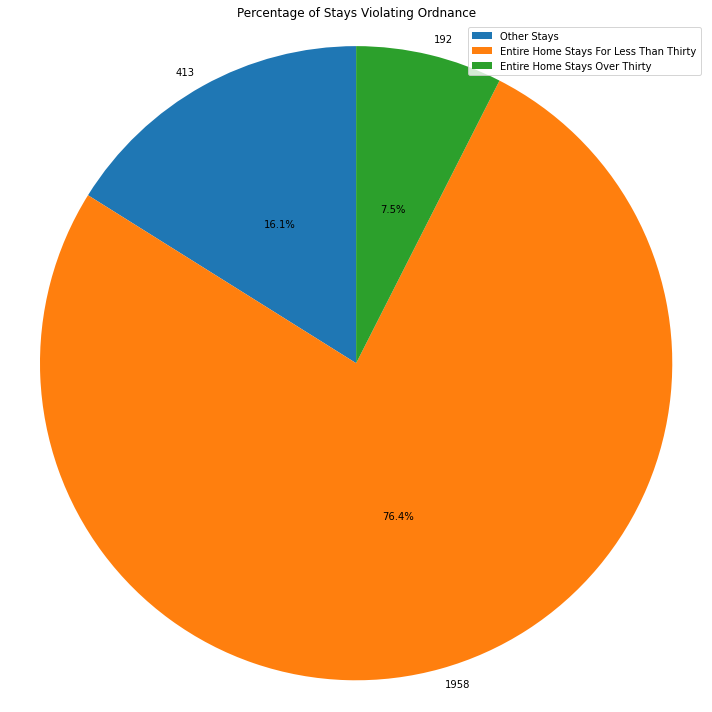

In [233]:
new_listings_with_cleaning_df = determine_avg_cleaning_fee(listings_detailed_df)
new_listings_df = keep_pertinent_listings_data(new_listings_with_cleaning_df)

price_median = calculate_distributions(new_listings_df,'price')[0]
price_mean = calculate_distributions(new_listings_df,'price')[1]
price_mode = calculate_distributions(new_listings_df,'price')[2]
price_min = calculate_distributions(new_listings_df,'price')[3]
price_max =calculate_distributions(new_listings_df,'price')[3]
price_first_quantile= int(calculate_distributions(new_listings_df,'price')[5][0.25])
min_logical_price = price_first_quantile * 25
max_prices = new_listings_df.query('(price > @min_logical_price) and (minimum_nights >=30)')['price']

price_corrected_df = determine_and_update_poss_mistaken_price(new_listings_df)
determine_entire_home_rentals_less_than_30_days_pie_chart(listings_detailed_df, price_corrected_df, title='Percentage of Stays Violating Ordnance')

prices = price_corrected_df['price']

In [207]:
new_listings_with_cleaning_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,cleaning_fee
0,108061,https://www.airbnb.com/rooms/108061,20211018161933,2021-10-18,Walk to stores/parks/downtown. Fenced yard/Pet...,Walk to town in ten minutes! Monthly rental in...,"I love my neighborhood! Its friendly, easy-goi...",https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,Lisa,2010-12-16,"Mills River, North Carolina, United States",I am a long time resident of Asheville and am ...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/320564/profil...,https://a0.muscache.com/im/users/320564/profil...,NaN,2,2,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Asheville, North Carolina, United States",28801,NaN,35.60670,-82.55563,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Dedicated workspace"", ""Dishes and silverware...",$82.00,30,365,30,30,1125,1125,30.0,1125.0,NaN,t,0,0,28,303,2021-10-18,89,0,0,2011-09-21,2019-11-30,4.49,4.57,4.70,4.85,4.79,4.84,4.48,NaN,f,2,2,0,0,0.73,50
1,155305,https://www.airbnb.com/rooms/155305,20211018161933,2021-10-18,Cottage! BonPaul + Sharky's Hostel,<b>The space</b><br />Private cottage located ...,"We are within easy walk of pubs, breweries, mu...",https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,BonPaul,2011-06-26,"Asheville, North Carolina, United States",We operate two traveler's hostels located in H...,within a few hours,69%,98%,f,https://a0.muscache.com/im/pictures/user/4dff7...,https://a0.muscache.com/im/pictures/user/4dff7...,NaN,7,7,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Asheville, North Carolina, United States",28806,NaN,35.57864,-82.59578,Entire guesthouse,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Dedicated workspace"", ""Dishes and silverware...",$92.00,1,365,1,1,7,365,1.0,143.9,NaN,t,14,40,70,207,2021-10-18,340,70,6,2016-08-29,2021-10-10,4.57,4.69,4.39,4.82,4.75,4.93,4.52,NaN,t,7,1,2,4,5.43,50
2,156805,https://www.airbnb.com/rooms/156805,20211018161933,2021-10-18,"Private Room ""Ader"" at BPS Hostel",<b>The space</b><br />Private Rooms at Bon Pau...,"Easy walk to pubs, cafes, bakery, breweries, l...",https://a0.muscache.com/pictures/23447d55-fa7e...,746673,https://www.airbnb.com/users/show/746673,BonPaul,2011-06-26,"Asheville, North Carolina, United States",We operate two traveler's hostels located in H...,within a few hours,69%,98%,f,https://a0.muscache.com/im/pictures/user/4dff7...,https://a0.muscache.com/im/pictures/user/4dff7...,NaN,7,7,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Asheville, North Carolina, United States",28806,NaN,35.57864,-82.59578,Private room in residential home,Private room,2,NaN,2.5 shared baths,1.0,1.0,"[""Dishes an

In [208]:
new_listings_df.head()

,id,name,neighborhood_overview,host_id,host_name,host_since,host_location,host_listings_count,host_total_listings_count,neighbourhood,latitude,longitude,room_type,bathrooms,bathrooms_text,bedrooms,price,minimum_nights,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,cleaning_fee,cleaners_fee_30,gross_income_30,percentage_occupied,net_income_30
1,155305,Cottage! BonPaul + Sharky's Hostel,"We are within easy walk of pubs, breweries, mu...",746673,BonPaul,2011-06-26,"Asheville, North Carolina, United States",7,7,Asheville,35.57864,-82.59578,Entire home/apt,NaN,1 bath,1.0,92,1,14,207,340,70,6,2016-08-29,2021-10-10,4.57,4.69,4.39,4.93,4.52,NaN,7,1,2,4,5.43,50,800.0,2272.0,53,1379.84
7,259576,"Private, peaceful, and free goat therapy",NaN,1362726,Julia,2011-11-02,"Asheville, North Carolina, United States",2,2,NaN,35.61929,-82.48114,Entire home/apt,NaN,1 bath,1.0,76,1,3,171,607,71,5,2018-12-18,2021-10-17,4.93,4.96,4.90,4.91,4.96,NaN,1,1,0,0,17.58,50,1350.0,3402.0,90,1909.44
10,353092,Athena's Loft: Find yourself here!,"Very walkable, and many friendly people in Wes...",1788071,Beth,2012-02-21,"Asheville, North Carolina, United States",1,1,Asheville,35.58217,-82.59997,Entire home/apt,NaN,1 bath,1.0,75,2,6,75,505,6,2,2017-09-04,2021-10-10,4.85,4.90,4.94,4.90,4.84,NaN,1,1,0,0,10.06,50,600.0,2400.0,80,1710.00
11,427497,Luxurious Mountain Guest Suite Apartment,The neighborhood is peaceful and quiet. It has...,1909922,Milan,2012-03-12,"Asheville, North Carolina, United States",1,1,Asheville,35.49111,-82.48438,Entire home/apt,NaN,1 bath,1.0,125,2,10,315,46,6,0,2020-12-30,2021-05-23,4.98,5.00,5.00,4.93,4.88,NaN,1,1,0,0,4.71,50,500.0,3000.0,66,2395.00
13,436476,"8 min Walk to DT AVL! Hip, Chic % Sparkling CLEAN",NaN,478398,Heidi,2011-04-02,"Asheville, North Carolina, United States",4,4,NaN,35.60182,-82.56174,Entire home/apt,NaN,1.5 baths,1.0,155,2,2,8,327,33,5,2014-04-23,2021-10-12,4.91,4.94,4.95,4.87,4.84,NaN,3,3,0,0,3.59,50,700.0,5040.0,93,4167.80


In [209]:
price_corrected_df.head()

,id,name,neighborhood_overview,host_id,host_name,host_since,host_location,host_listings_count,host_total_listings_count,neighbourhood,latitude,longitude,room_type,bathrooms,bathrooms_text,bedrooms,price,minimum_nights,availability_30,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_location,review_scores_value,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,cleaning_fee,cleaners_fee_30,gross_income_30,percentage_occupied,net_income_30
1,155305,Cottage! BonPaul + Sharky's Hostel,"We are within easy walk of pubs, breweries, mu...",746673,BonPaul,2011-06-26,"Asheville, North Carolina, United States",7,7,Asheville,35.57864,-82.59578,Entire home/apt,NaN,1 bath,1.0,92,1,14,207,340,70,6,2016-08-29,2021-10-10,4.57,4.69,4.39,4.93,4.52,NaN,7,1,2,4,5.43,50,800.0,2272.0,53,1379.84
7,259576,"Private, peaceful, and free goat therapy",NaN,1362726,Julia,2011-11-02,"Asheville, North Carolina, United States",2,2,NaN,35.61929,-82.48114,Entire home/apt,NaN,1 bath,1.0,76,1,3,171,607,71,5,2018-12-18,2021-10-17,4.93,4.96,4.90,4.91,4.96,NaN,1,1,0,0,17.58,50,1350.0,3402.0,90,1909.44
10,353092,Athena's Loft: Find yourself here!,"Very walkable, and many friendly people in Wes...",1788071,Beth,2012-02-21,"Asheville, North Carolina, United States",1,1,Asheville,35.58217,-82.59997,Entire home/apt,NaN,1 bath,1.0,75,2,6,75,505,6,2,2017-09-04,2021-10-10,4.85,4.90,4.94,4.90,4.84,NaN,1,1,0,0,10.06,50,600.0,2400.0,80,1710.00
11,427497,Luxurious Mountain Guest Suite Apartment,The neighborhood is peaceful and quiet. It has...,1909922,Milan,2012-03-12,"Asheville, North Carolina, United States",1,1,Asheville,35.49111,-82.48438,Entire home/apt,NaN,1 bath,1.0,125,2,10,315,46,6,0,2020-12-30,2021-05-23,4.98,5.00,5.00,4.93,4.88,NaN,1,1,0,0,4.71,50,500.0,3000.0,66,2395.00
13,436476,"8 min Walk to DT AVL! Hip, Chic % Sparkling CLEAN",NaN,478398,Heidi,2011-04-02,"Asheville, North Carolina, United States",4,4,NaN,35.60182,-82.56174,Entire home/apt,NaN,1.5 baths,1.0,155,2,2,8,327,33,5,2014-04-23,2021-10-12,4.91,4.94,4.95,4.87,4.84,NaN,3,3,0,0,3.59,50,700.0,5040.0,93,4167.80


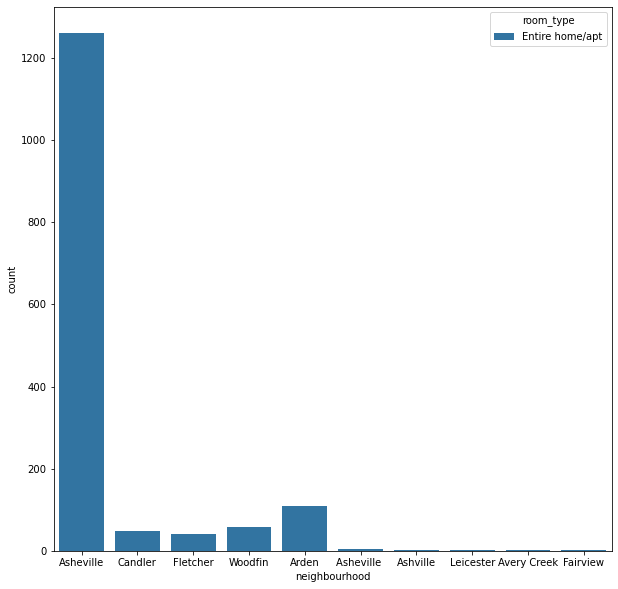

In [127]:
plt.figure(figsize=(10,10))
ax = sns.countplot(price_corrected_df['neighbourhood'],hue=price_corrected_df['room_type'])

In [128]:
def draw_map(df):
    asheville_center = [df.latitude.mean(), df.longitude.mean()]
    zones = df.groupby('neighbourhood').mean().reset_index()
    zone_name = zones['neighbourhood'].values.tolist()
    zone_loc = zones[['latitude', 'longitude']].values.tolist()

    base_map = fl.Map(location = asheville_center, control_scale = True, zoom_start = 12, tiles = 'OpenStreetMap')

    for i in range(len(zone_name)):
        attr = {'fill': 'midnightblue', 'font-weight': 'bold', 'font-size': '20'}
        pl = fl.PolyLine([[zone_loc[i][0], zone_loc[i][1]-.1], [zone_loc[i][0], zone_loc[i][1]+.1]], weight = 15, color = 'rgb(255,255,255, 0)')
        base_map.add_child(pl)
        base_map.add_child(PolyLineTextPath(pl, text = zone_name[i], attributes = attr, center = True))
    
    return base_map

base_map = draw_map(price_corrected_df)    
base_map.add_child(HeatMap(data = price_corrected_df[['latitude', 'longitude']], min_opacity = 0.4, radius = 15, blur = 40))
base_map.add_child(fl.ClickForMarker(popup='High amount of listings'))
outfp='images/Asheville.html'
base_map.save(outfp)

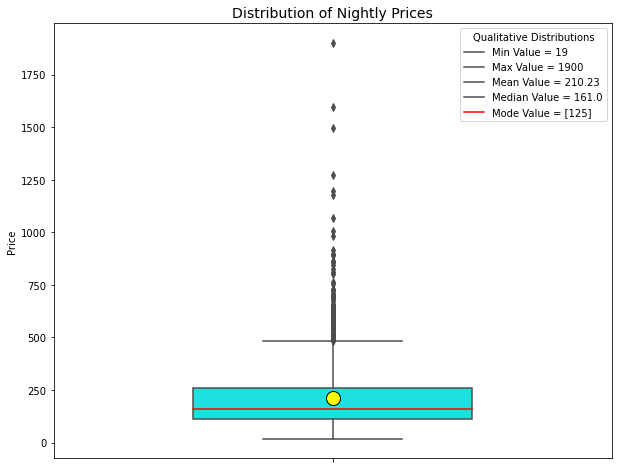

In [129]:
get_qualitative_dist_box_plot(price_corrected_df,'price', 'Price', 'Distribution of Nightly Prices', 'Price Distribution boxplot', color=
                             'cyan')

In [130]:
number_of_listings_per_host = price_corrected_df['host_listings_count'].value_counts().index.sort_values(ascending=False)
print(number_of_listings_per_host)

Int64Index([729, 574, 505, 244, 188, 171, 127, 111, 110,  28,  25,  22,  21,
             18,  16,  15,  14,  13,  11,  10,   9,   8,   7,   6,   5,   4,
              3,   2,   1,   0],
           dtype='int64')


In [131]:
price_corrected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1958 entries, 1 to 2561
Data columns (total 38 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1958 non-null   int64  
 1   name                                          1958 non-null   object 
 2   neighborhood_overview                         1529 non-null   object 
 3   host_id                                       1958 non-null   int64  
 4   host_name                                     1958 non-null   object 
 5   host_since                                    1958 non-null   object 
 6   host_location                                 1955 non-null   object 
 7   host_listings_count                           1958 non-null   int64  
 8   host_total_listings_count                     1958 non-null   int64  
 9   neighbourhood                                 1529 non-null   o

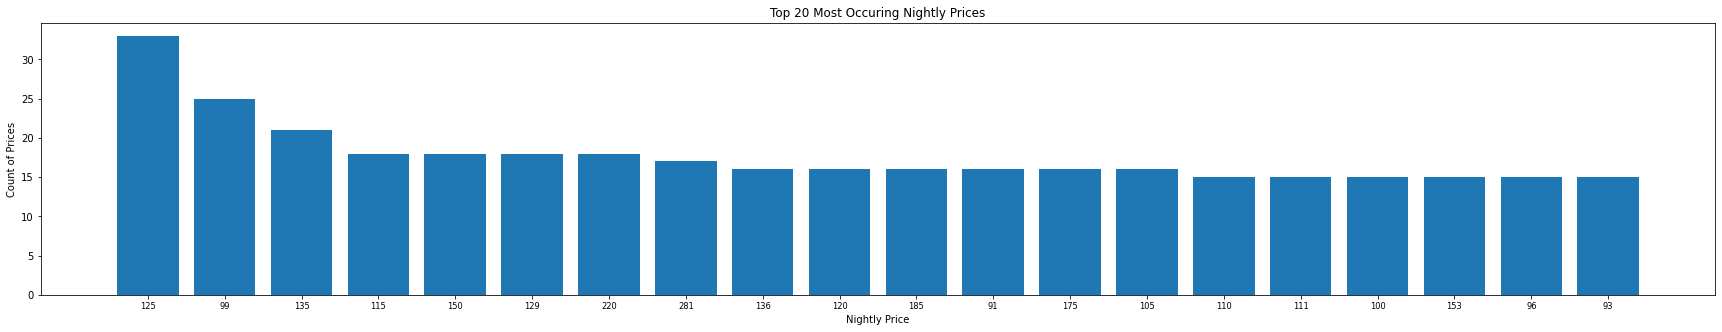

In [132]:
price_values=prices.value_counts()[:20]
plt.figure(figsize=(30,5))
plt.bar(range(len(price_values)), price_values.values, align='center',)
plt.xticks(range(len(price_values)), price_values.index.values, size='small')
plt.title('Top 20 Most Occuring Nightly Prices')
plt.ylabel('Count of Prices')
plt.xlabel('Nightly Price')
plt.savefig('images/Top 20 Most Occuring Nightly Prices.png')
plt.show()

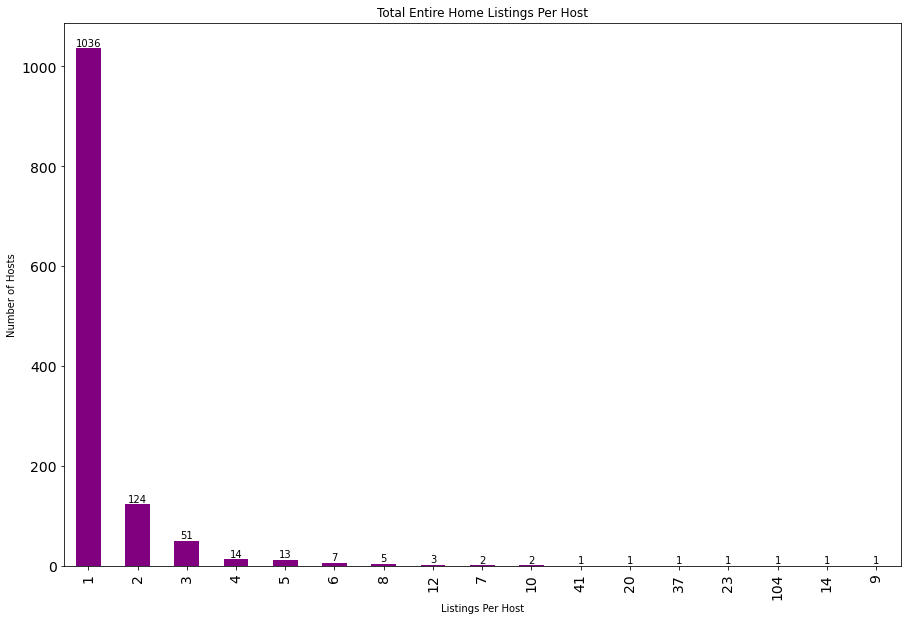

In [133]:
price_corrected_df.groupby(by='host_id')['calculated_host_listings_count_entire_homes'].count().value_counts().plot(xlabel='Listings Per Host', 
                                                                                                                    ylabel= 'Number of Hosts', kind='bar', 
                                                                                                                    figsize=(15,10), title= 'Total Entire Home Listings Per Host', 
                                                                                                                    color='purple',
                                                                                                                   fontsize=14)

indexes= price_corrected_df.groupby(by='host_id')['calculated_host_listings_count_entire_homes'].count().value_counts().values
for i in range(0,len(indexes)):
    plt.annotate(str(indexes[i]), xy=(i,indexes[i]),ha='center', va='bottom')
plt.savefig('images/Total Entire Home Listings per Host.png')




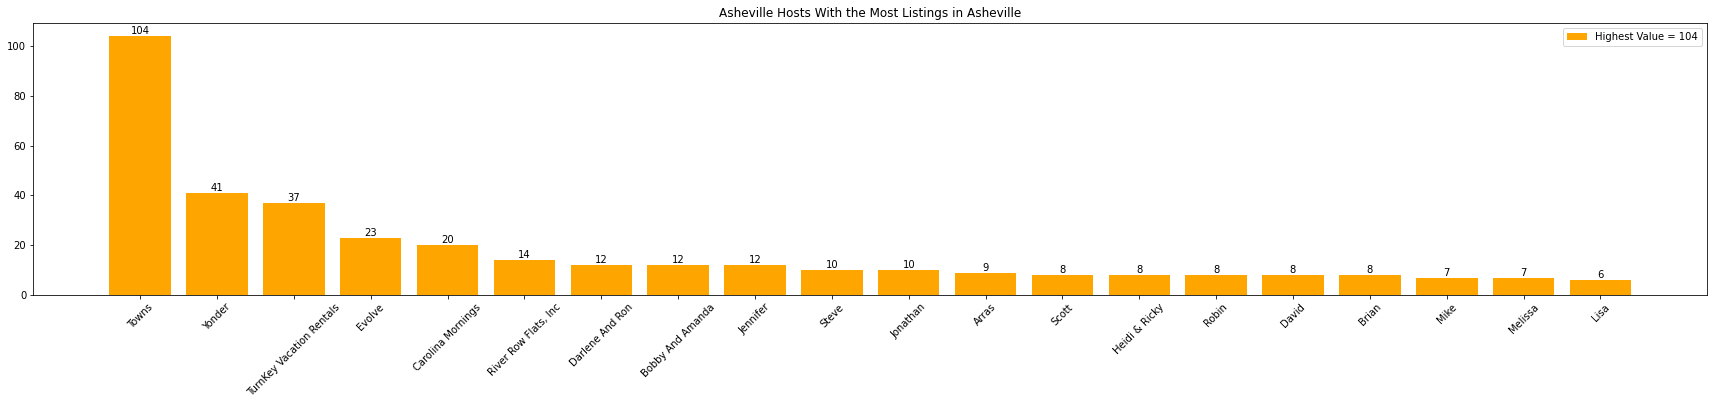

<AxesSubplot:>

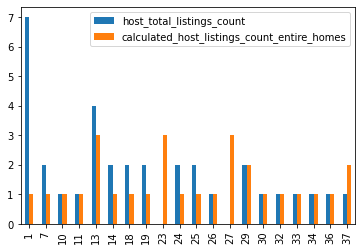

In [134]:
make_bar_chart_from_column_values_with_names_top20(price_corrected_df,'host_id', 'host_name', figsize=(30,5), title='Asheville Hosts With the Most Listings in Asheville', color='Orange', imagename='Hosts With the Mosts_names')

price_corrected_df[["host_total_listings_count", "calculated_host_listings_count_entire_homes"]][:20].plot(kind="bar", stacked=False)


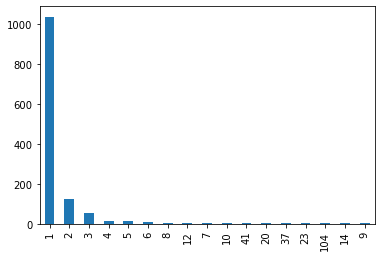

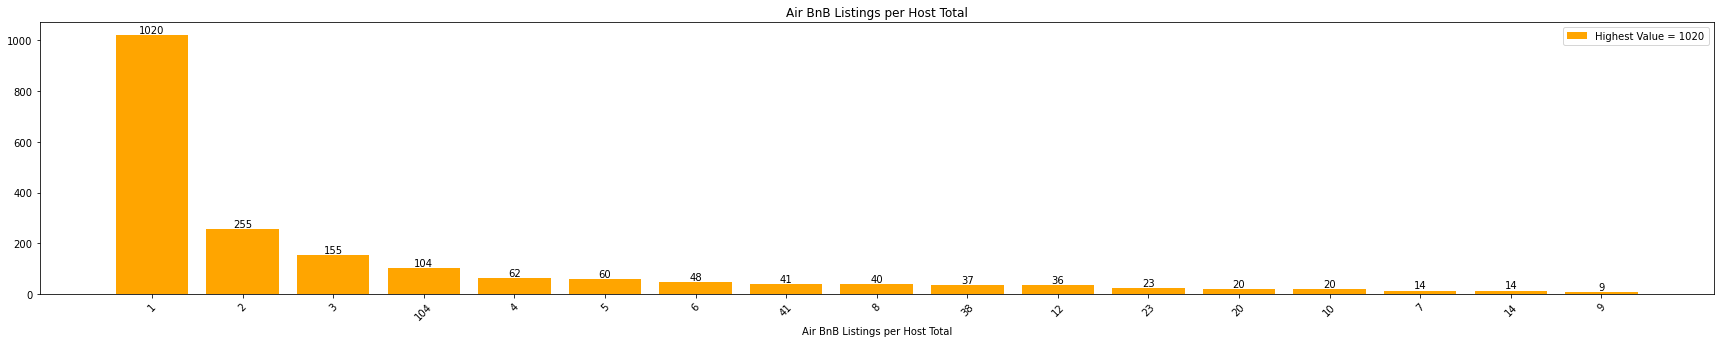

In [135]:
price_corrected_df.groupby(by='host_id')['calculated_host_listings_count_entire_homes'].count().value_counts().plot(kind='bar')
make_bar_chart_from_column_values_with_values_top20(price_corrected_df,'calculated_host_listings_count_entire_homes', title='Air BnB Listings per Host Total', imagename='Bar Chart For Total Listings By Host in AirBnB')

In [136]:
price_corrected_df.query('calculated_host_listings_count_entire_homes > 10')['host_total_listings_count'].sort_values()

1328     14
1311     14
1312     14
1313     14
1314     14
       ... 
1444    729
1452    729
1503    729
1971    729
1660    729
Name: host_total_listings_count, Length: 275, dtype: int64

In [71]:
# host_local_listings = price_corrected_df['calculated_host_listings_count_entire_homes'].groupby(price_corrected_df['host_id']).count().sort_values(ascending=False)[:20]
# host_total_listings = price_corrected_df['host_total_listings_count'].groupby(price_corrected_df['host_id']).count().sort_values(ascending=False)[:20]


# #price_corrected_df.groupby(by='host_id')['calculated_host_listings_count_entire_homes'].count().value_counts().index
# price_corrected_df.groupby(price_corrected_df['host_id'])['host_total_listings_count'].value_counts().sort_values

host_id    host_total_listings_count
62667      3                            2
167473     5                            3
168588     2                            1
187672     1                            1
266195     0                            1
                                       ..
422190367  0                            1
424026604  0                            1
424428643  0                            2
424974832  0                            4
425601651  0                            1
Name: host_total_listings_count, Length: 1264, dtype: int64

In [50]:
price_corrected_df[['calculated_host_listings_count_entire_homes','host_total_listings_count']].groupby(price_corrected_df['host_id']).count().sort_values(by='host_total_listings_count',ascending=False)

,calculated_host_listings_count_entire_homes,host_total_listings_count
host_id,,
167186184,104,104
96187307,41,41
149601167,37,37
151397468,23,23
134903005,20,20
...,...,...
39527624,1,1
40029825,1,1
40292535,1,1


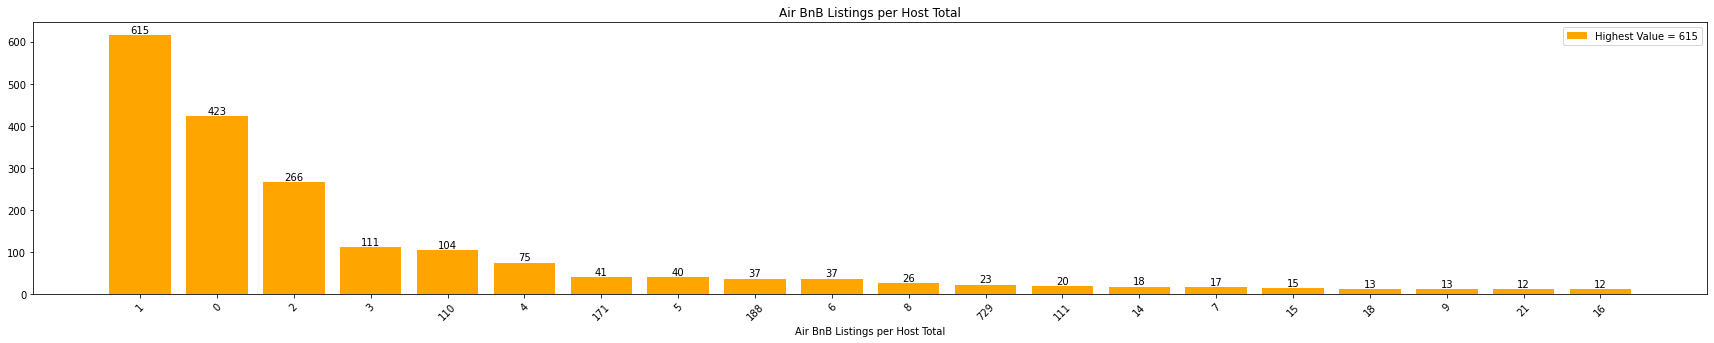

In [137]:
#it's likely that the host_listings_count field isn't used anymore as there were zero values in 535 of the data 
make_bar_chart_from_column_values_with_values_top20(new_listings_df,'host_listings_count', title='Air BnB Listings per Host Total', imagename='Bar Chart For Most Listings By Host in AirBnB')

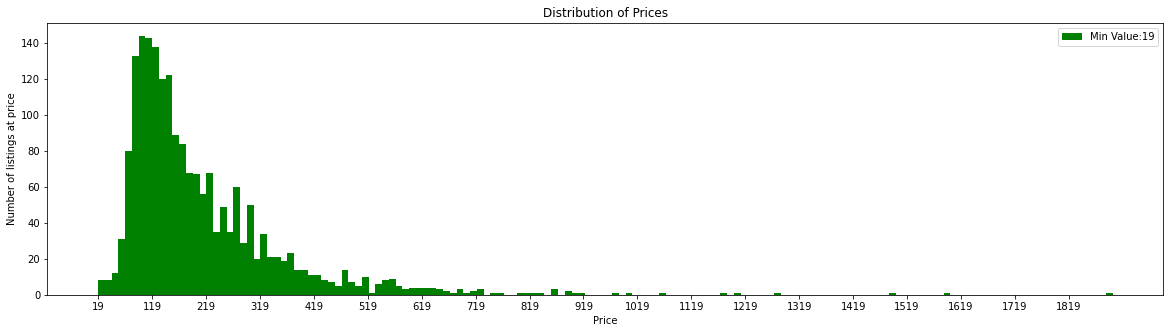

In [138]:
build_distribution_histogram(prices,'green',[20,5],150,100,'Number of listings at price','Price','Distribution of Prices','prices_function_graph')

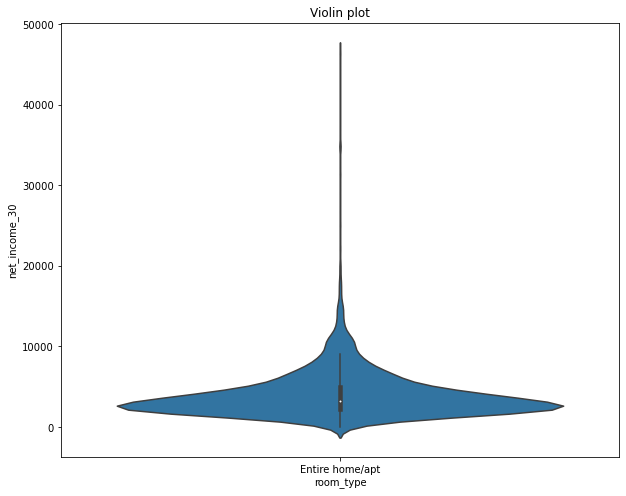

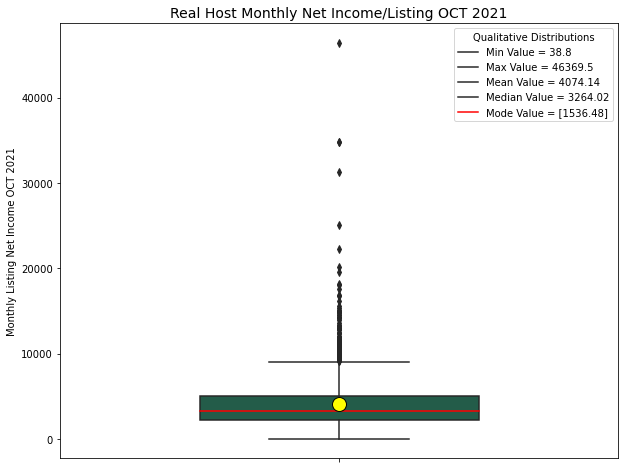

In [259]:
fig, ax = plt.subplots(figsize=(10, 8))  
sns.violinplot(x='room_type', y='net_income_30', data=price_corrected_df, ax=ax)  
ax.set_title('Violin plot')  
plt.show()
get_qualitative_dist_box_plot(price_corrected_df, 'net_income_30', 'Monthly Listing Net Income OCT 2021','Real Host Monthly Net Income/Listing OCT 2021','Real Host Monthly Net Income OCT 2021', color=(0.1, 0.4, 0.3))

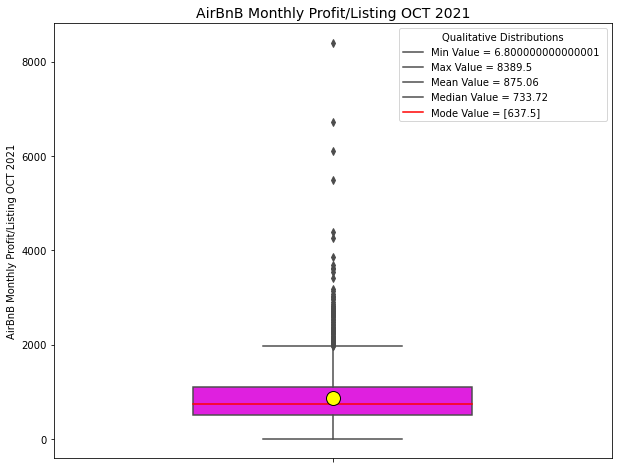

In [261]:
get_qualitative_dist_box_plot(price_corrected_df, 'airbnb_profit_30', 'AirBnB Monthly Profit/Listing OCT 2021','AirBnB Monthly Profit/Listing OCT 2021','AirBnB Monthly Profit OCT 2021', color='magenta')

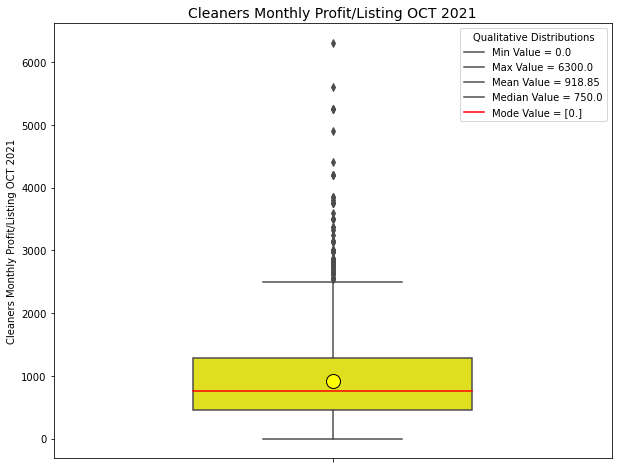

In [262]:
get_qualitative_dist_box_plot(price_corrected_df, 'cleaners_fee_30', 'Cleaners Monthly Profit/Listing OCT 2021','Cleaners Monthly Profit/Listing OCT 2021','Cleaners Monthly Profit OCT 2021', color='yellow')

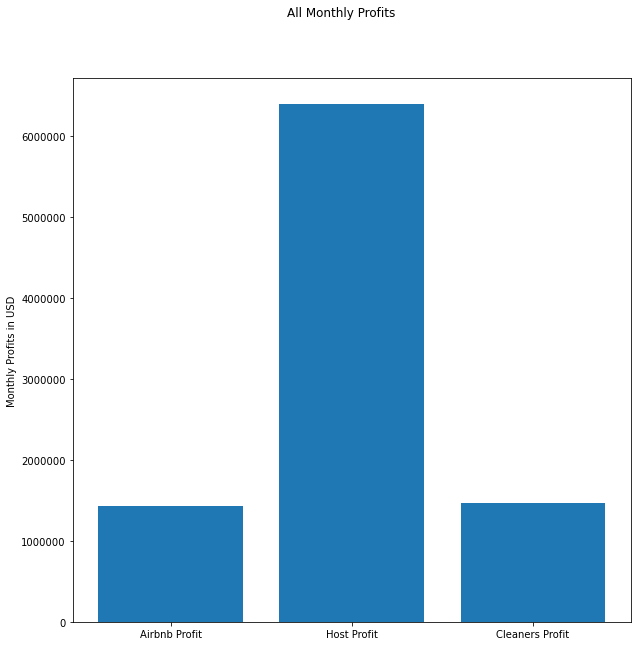

In [263]:
def determine_theoretical_profit(df,median_value):
    return median_value * len(df)

calculate_distributions(price_corrected_df,'airbnb_profit_30')[0] * len(price_corrected_df)


total_airbnb_profit = determine_theoretical_profit(price_corrected_df,calculate_distributions(price_corrected_df,'airbnb_profit_30')[0])
total_host_profit = determine_theoretical_profit(price_corrected_df,calculate_distributions(price_corrected_df,'net_income_30')[0])
total_cleaners_profit = determine_theoretical_profit(price_corrected_df,calculate_distributions(price_corrected_df,'cleaners_fee_30')[0])

names = ['Airbnb Profit', 'Host Profit', 'Cleaners Profit']
values = [int(total_airbnb_profit), int(total_host_profit), int(total_cleaners_profit)]
fig,ax = plt.subplots(figsize=(10,10))
plt.bar(names, values)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.ylabel('Monthly Profits in USD')
plt.suptitle('All Monthly Profits ')
plt.savefig('images/All Monthly Profits.png')
plt.show()
